## 12/12/23

This notebook takes differential expression results from running MAST and runs EnrichR on significantly upregulated genes in different myeloid celltypes. I also remake HSPC/celltype correlation plots based on gene programs of interest.

# Imports

In [49]:
import rpy2
import anndata
import os
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import anndata
import warnings
import gseapy
import sys
from matplotlib.backends.backend_pdf import PdfPages
sys.path.insert(1, 'ramaiar/scripts_from_lucy/lkp-sc-tools')
import lkpsctools.plotting as lkplot
import openpyxl

# Inputs

In [4]:
full_mast_res_save_path = '/data/niecr/cheongj/misc/results_seurat/DGE/final_results/hspc_MISC-recovered_VS_all_MAST.xlsx'

In [5]:
enrichr_res_save_path = '/data/niecr/cheongj/misc/results_seurat/DGE/final_results/gsea_hspc_MISC-recovered_VS_all_MAST.xlsx'

In [6]:
enrichr_fig_save_path = '/data/niecr/cheongj/misc/results_seurat/DGE/final_results/gsea_hspc_MISC-recovered_VS_all_MAST.pdf'

# Load in and filter gene lists

In [7]:
diff_exp = pd.read_excel(full_mast_res_save_path, sheet_name = None)

In [9]:
diff_exp.keys()

dict_keys(['Baseline_MIS-C', 'D28_MIS-C', 'Baseline_COVID', 'D28_COVID', 'M6_COVID', 'M12_COVID', 'D28_COVID_VS_Baseline_MIS-C'])

In [11]:
diff_genes_dict = {'up': {}, 'down': {}}
FDR_CUTOFF = 0.01

for conditions in diff_exp.keys():
    
    df = diff_exp[conditions]
    df = df[~np.isnan(df['coef'])]
    
    sig_up_genes = df[(df['fdr'] < FDR_CUTOFF) & (df['coef'] > 0)]['primerid']
    good_up_genes = sig_up_genes[~sig_up_genes.str.startswith(('RPS', 'RPL', 'MT'))].tolist()
    
    sig_down_genes = df[(df['fdr'] < FDR_CUTOFF) & (df['coef'] < 0)]['primerid']
    good_down_genes = sig_down_genes[~sig_down_genes.str.startswith(('RPS', 'RPL', 'MT'))].tolist()
    
    diff_genes_dict['up'][conditions] = good_up_genes
    diff_genes_dict['down'][conditions] = good_down_genes

# Run EnrichR

In [25]:
enrichr_res_d = {'up': {}, 'down': {}}
for conditions in diff_exp.keys():
    enrichr_res_d[conditions] = {}
    genelist_up = diff_genes_dict['up'][conditions]
    # run w GO_Biological_Process
    enrichr_res_d['up'][conditions] = gseapy.enrichr(genelist_up,
                    gene_sets='GO_Biological_Process_2021',
                    organism = 'human',
                    outdir=None)

# Plot EnrichR results

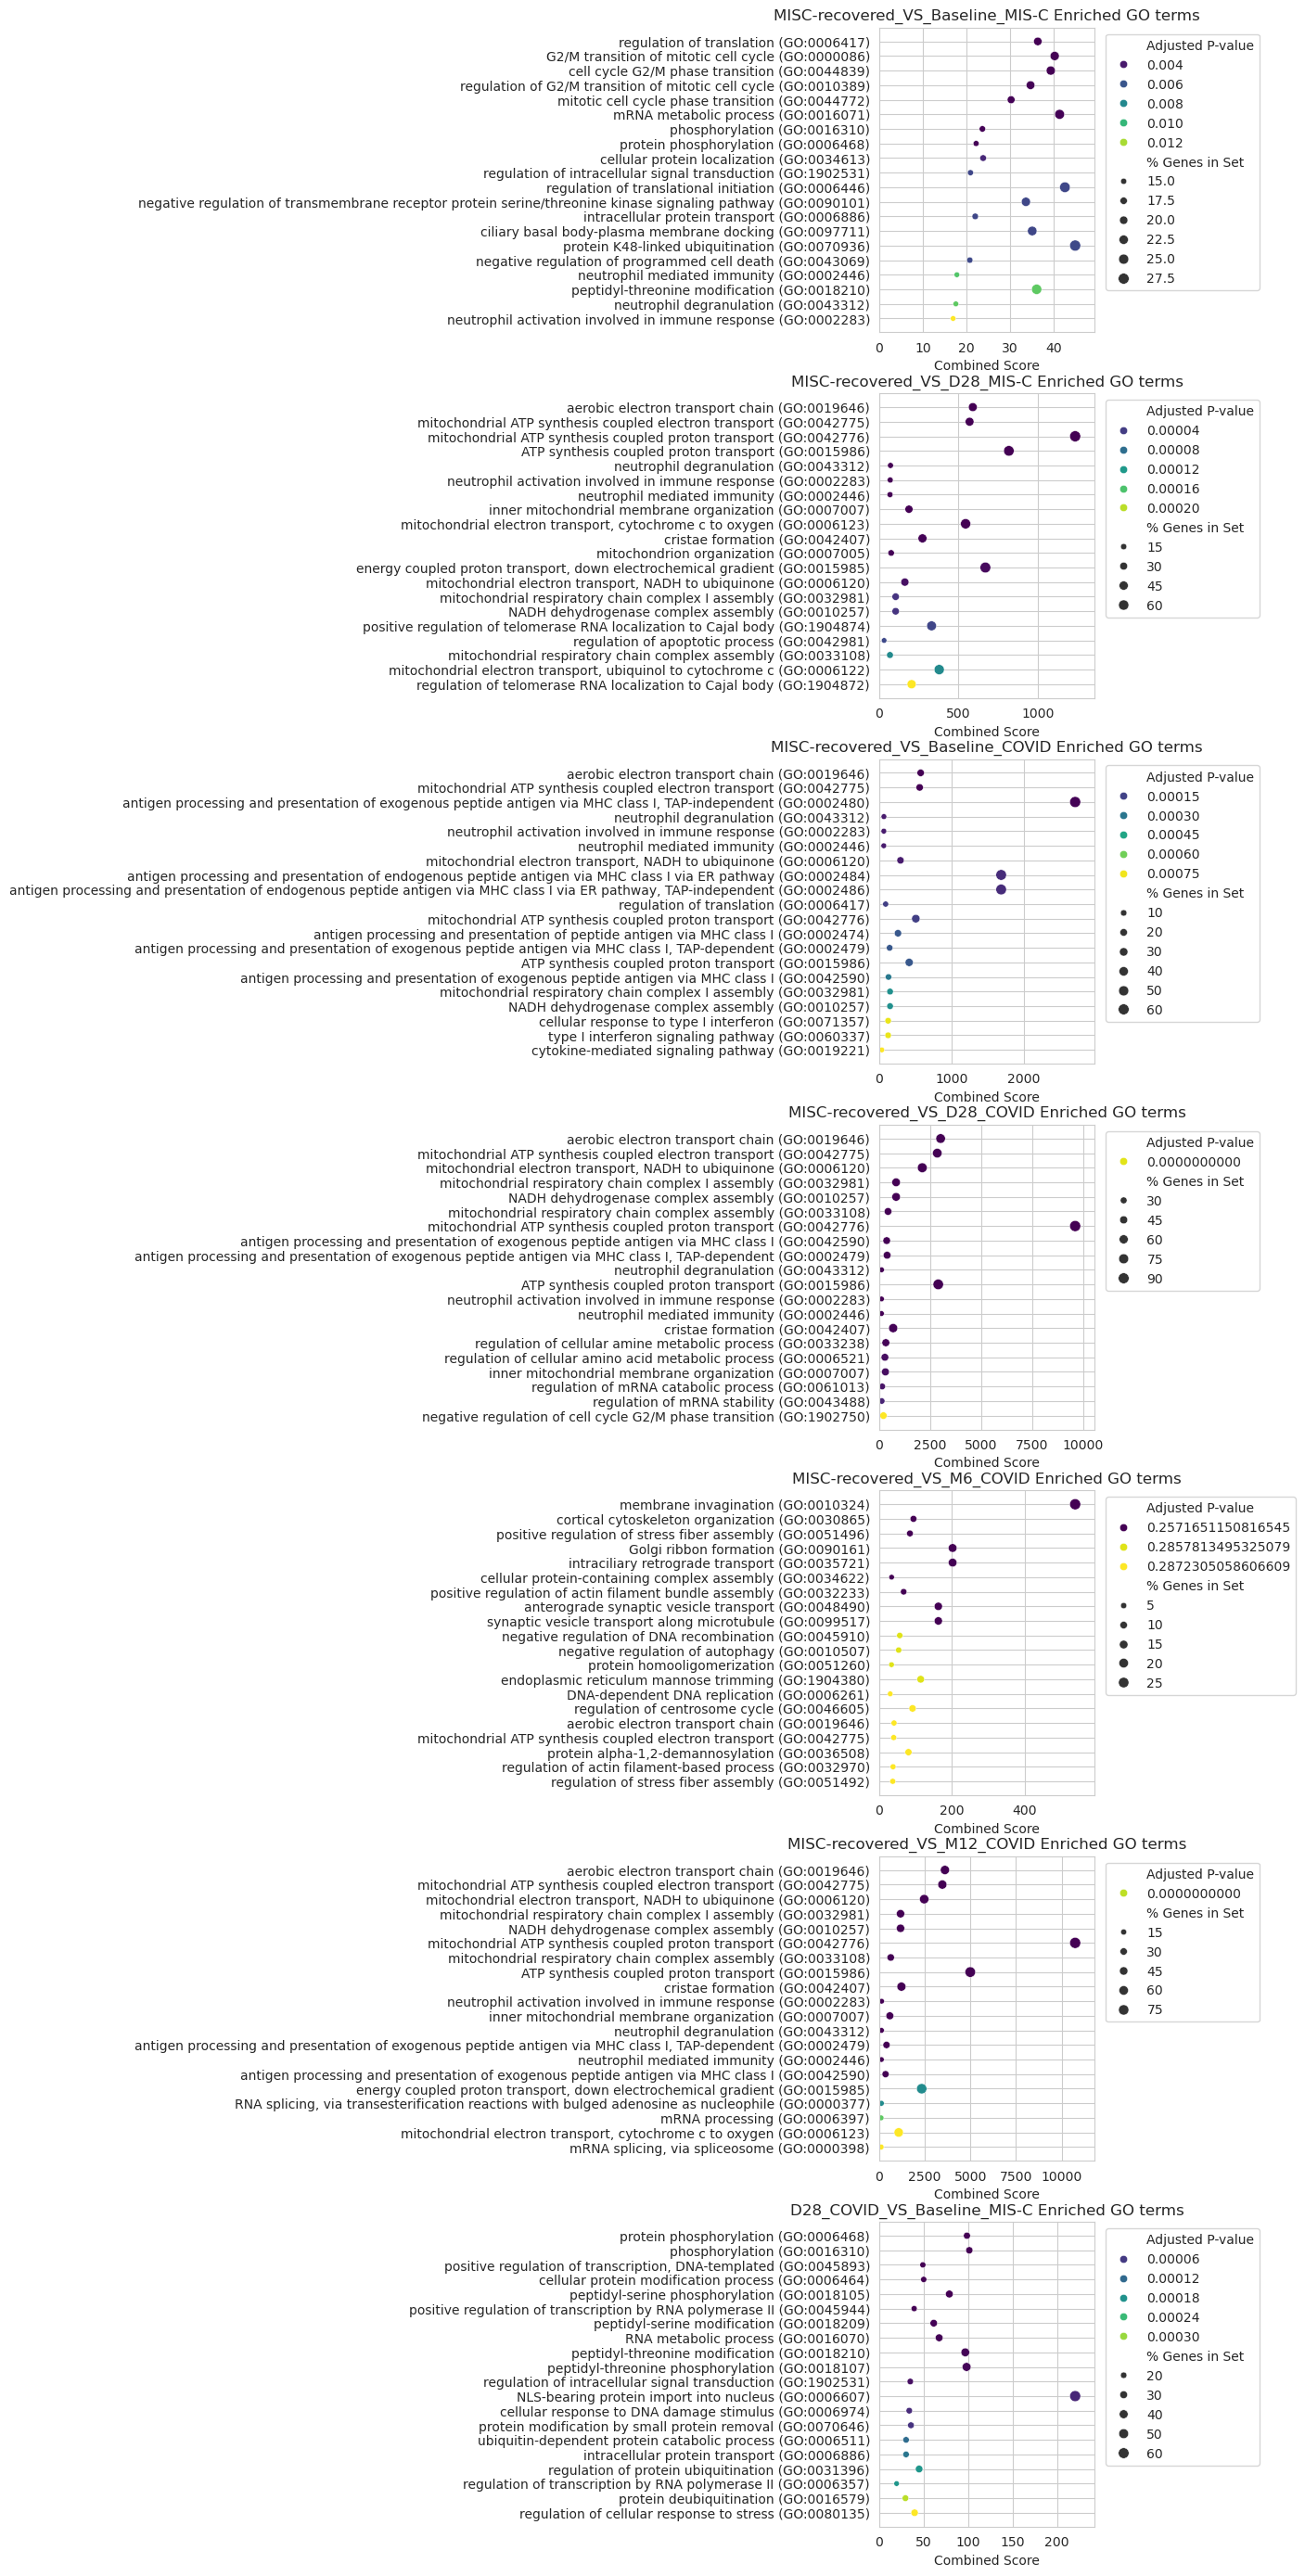

In [42]:
sns.set_style('whitegrid')

fig1, axs = plt.subplots(len(diff_exp.keys()),1, figsize = (3,5*len(diff_exp.keys())))

for i, conditions in enumerate(diff_exp.keys()):
    ax = axs[i]
    
    # prep df
    df = enrichr_res_d['up'][conditions].res2d.iloc[:20].copy()
    df['-log10(Adjusted P-value)'] = -np.log10(df['Adjusted P-value'])
    df['Num shared genes'] = df['Overlap'].str.split('/').str[0].astype(int)
    df['Num genes in set'] = df['Overlap'].str.split('/').str[1].astype(int)
    df['% Genes in Set'] = (df['Num shared genes']/df['Num genes in set']) * 100

    # Create the bubble plot
    sns.scatterplot(data=df, x='Combined Score', y='Term', size='% Genes in Set', hue = 'Adjusted P-value', ax = ax, palette = 'viridis')
    buffer = max(df['Combined Score']) * 0.1
    ax.set_xlim(0, max(abs(df['Combined Score'])) + buffer)
    
    # set legend location
    legend1 = ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    
    if conditions != 'D28_COVID_VS_Baseline_MIS-C':
        title = 'MISC-recovered_VS_'+conditions
    else:
        title = conditions
    # Set the axis labels
    ax.set(xlabel = 'Combined Score', ylabel = '', title = title + ' Enriched GO terms')

In [45]:
with pd.ExcelWriter(enrichr_res_save_path) as writer:
    for key in enrichr_res_d['up'].keys():
        df = enrichr_res_d['up'][key].res2d
        if key != 'D28_COVID_VS_Baseline_MIS-C':
            sheet_name = 'MISC-recovered_VS_'+key
        else:
            sheet_name = key
        df.to_excel(writer, sheet_name=sheet_name, index = False) 

/home/ramaiar1/miniconda3/envs/multiome_winner_test3/lib/python3.8/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


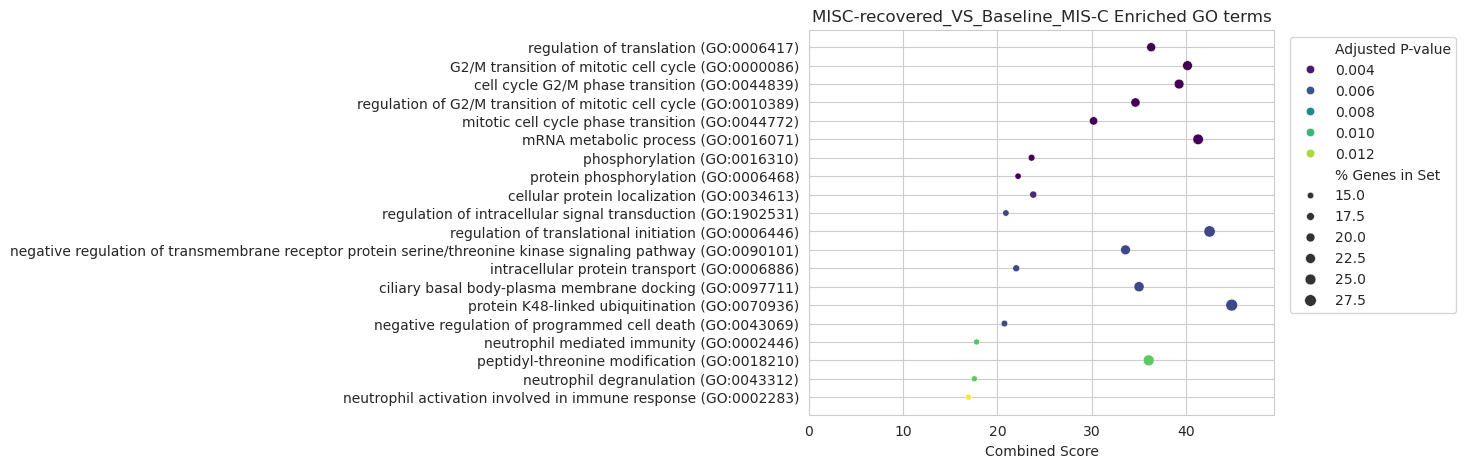

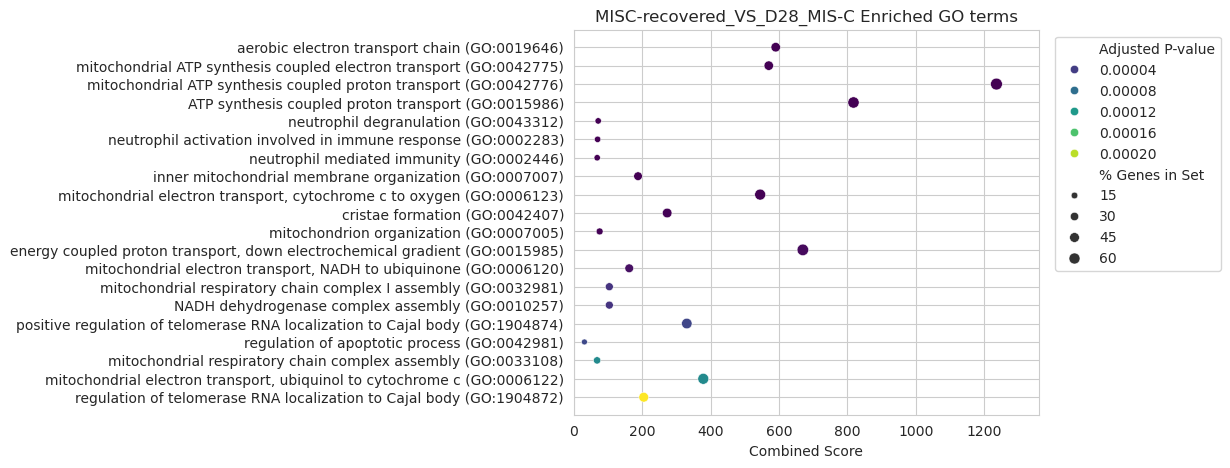

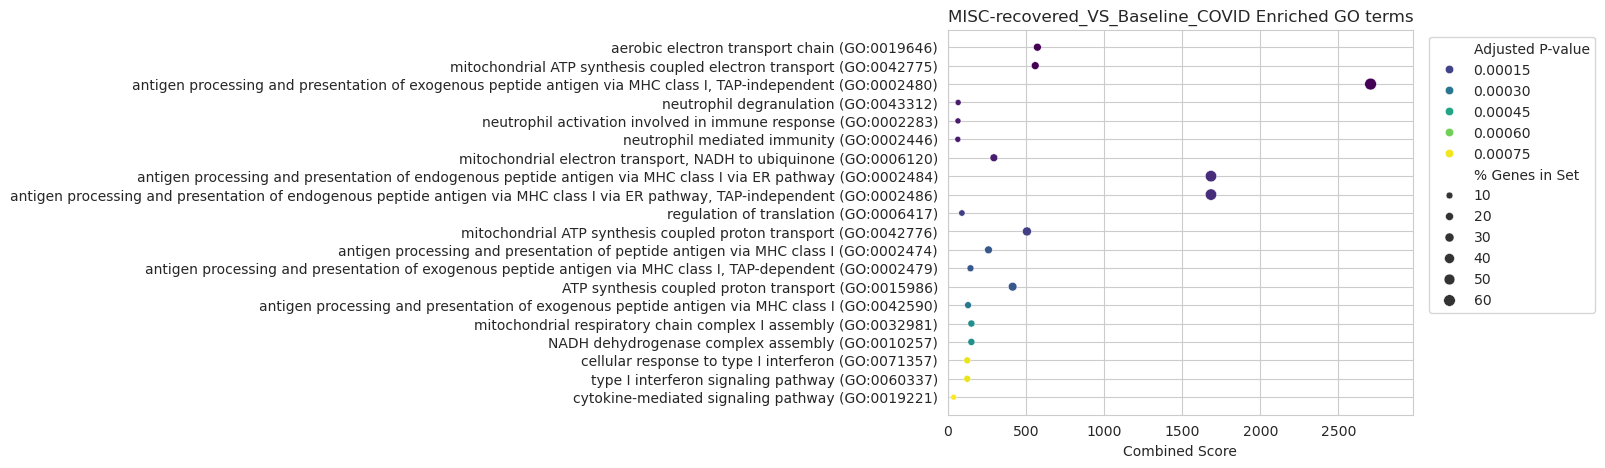

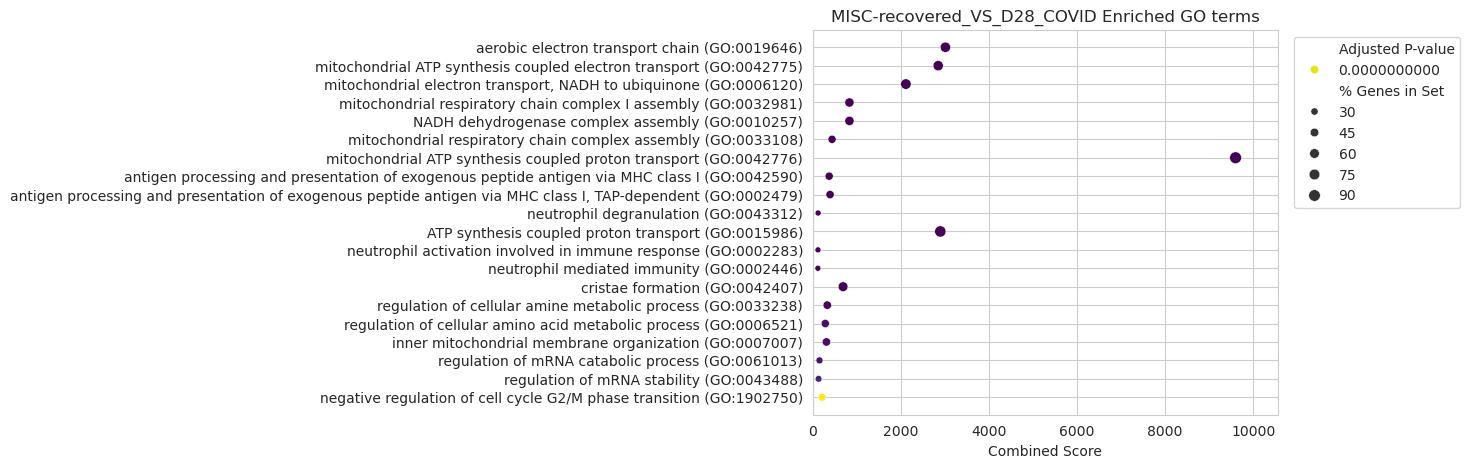

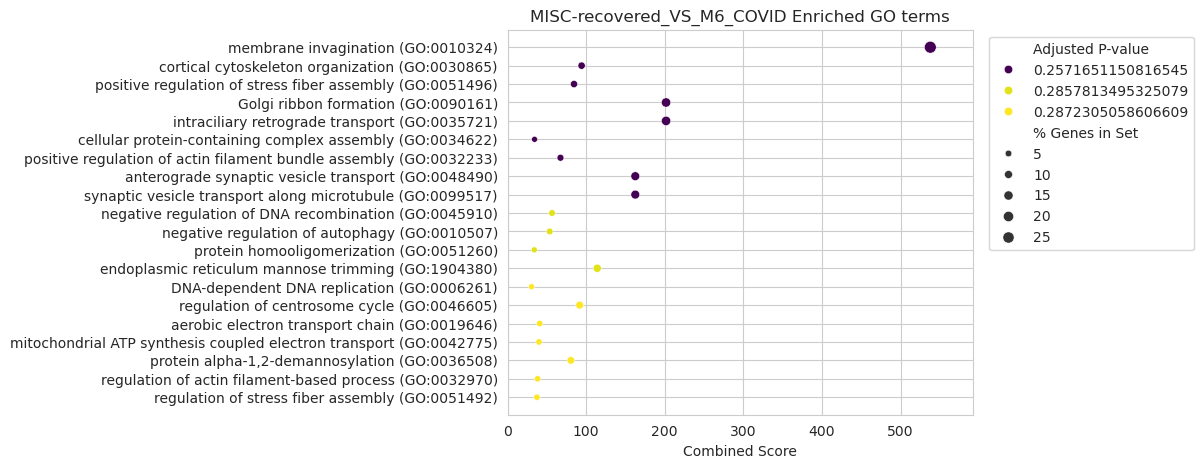

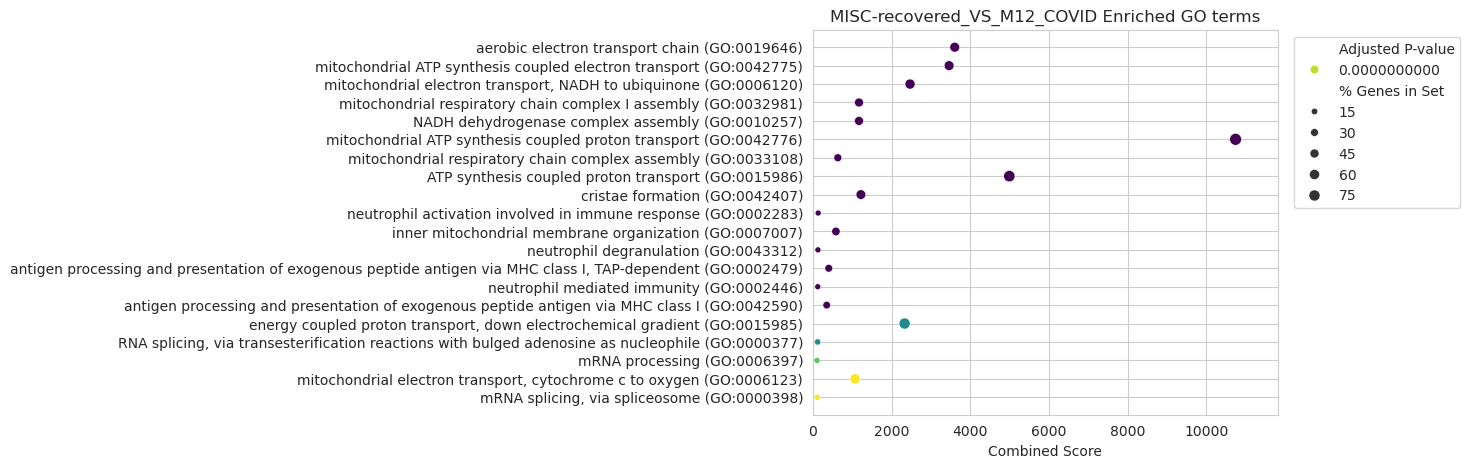

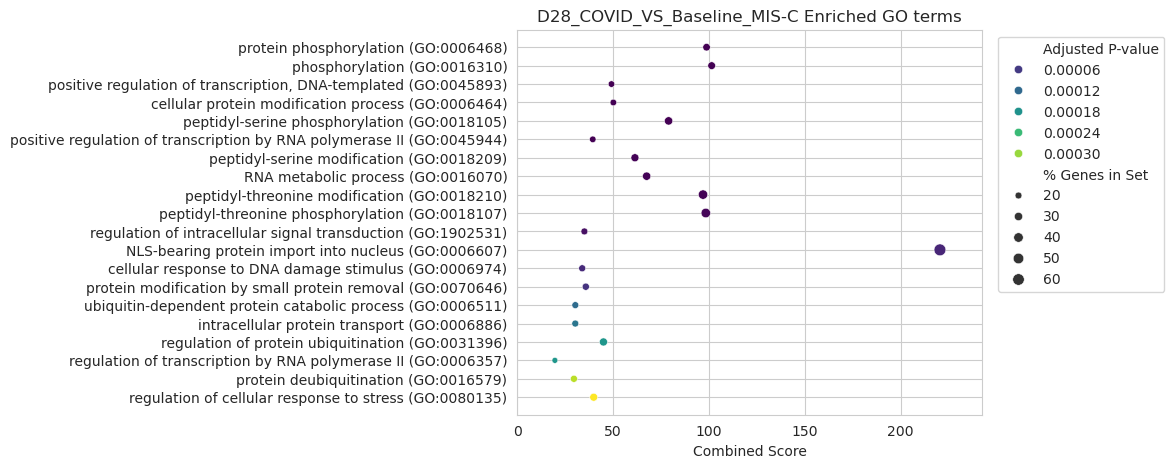

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages

sns.set_style('whitegrid')

pdf = PdfPages(enrichr_fig_save_path)

# Iterate over each condition
for conditions in diff_exp.keys():
    # Create a new figure for each plot
    fig, ax = plt.subplots(figsize=(6, 5))
    
    # Prep df
    df = enrichr_res_d['up'][conditions].res2d.iloc[:20].copy()
    df['-log10(Adjusted P-value)'] = -np.log10(df['Adjusted P-value'])
    df['Num shared genes'] = df['Overlap'].str.split('/').str[0].astype(int)
    df['Num genes in set'] = df['Overlap'].str.split('/').str[1].astype(int)
    df['% Genes in Set'] = (df['Num shared genes'] / df['Num genes in set']) * 100

    # Create the bubble plot
    sns.scatterplot(data=df, x='Combined Score', y='Term', size='% Genes in Set', hue='Adjusted P-value', ax=ax, palette='viridis')
    buffer = max(df['Combined Score']) * 0.1
    ax.set_xlim(0, max(abs(df['Combined Score'])) + buffer)
    
    # Set legend location
    legend1 = ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    
    # Set the title
    if conditions != 'D28_COVID_VS_Baseline_MIS-C':
        title = 'MISC-recovered_VS_' + conditions
    else:
        title = conditions
    
    # Set the axis labels and title
    ax.set(xlabel='Combined Score', ylabel='', title=title + ' Enriched GO terms')
    
    # Save the current figure to the PDF
    pdf.savefig(fig, bbox_inches='tight')
    plt.show()
    plt.close(fig)  # Close the figure to avoid display in Jupyter Notebook

# Close the PdfPages object
pdf.close()
